In [1]:
import sys
sys.path.insert(0, '../')
from functions import *

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
# Random Seed for dataset generation
sampling_seed = 15
torch.manual_seed(sampling_seed)

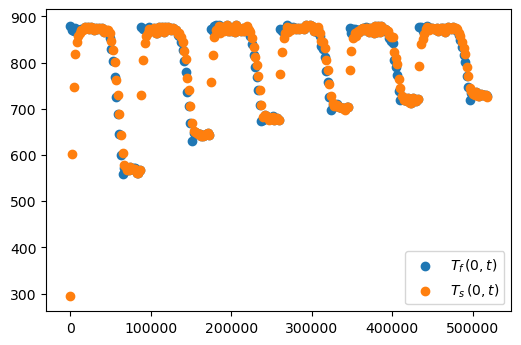

In [2]:
data = pd.read_table('TrainingData.txt', delimiter=',', dtype='float')
t = torch.tensor(data.t).reshape(-1,1)
tf0 = torch.tensor(data.tf0).reshape(-1,1)
ts0 = torch.tensor(data.ts0).reshape(-1,1)

data_mean = np.array([t.mean(), tf0.mean(), ts0.mean()])
data_std = np.array([t.std(), tf0.std(), ts0.std()])

t_norm = (t-data_mean[0])/data_std[0]
tf0_norm = (tf0-data_mean[1])/data_std[1]
ts0_norm = (ts0-data_mean[2])/data_std[2]

validation_size = int(0*t_norm.shape[0]/100)
training_size = t_norm.shape[0] - validation_size
t_train = t_norm[:training_size]
tf0_train = tf0_norm[:training_size]
ts0_train = ts0_norm[:training_size]

t_val = t_norm[training_size:]
tf0_val = tf0_norm[training_size:]
ts0_val = ts0_norm[training_size:]

# Plot
plt.figure()
plt.scatter(t,tf0)
plt.scatter(t,ts0)
plt.legend(['$T_f\,(0,t)$','$T_s\,(0,t)$'])
plt.show()

network_properties = {
    "hidden_layers": [4, 10],
    "neurons": [20, 50],
    "regularization_exp": [2],
    "regularization_param": np.linspace(0, 0.03, 5).tolist(),
    "batch_size": [t_train.shape[0]],
    "epochs": [5000],
    "optimizer": ["LBFGS"],
    "init_weight_seed": [np.random.randint(0,100)]
}

settings = list(itertools.product(*network_properties.values()))

i = 0

train_err_conf = list()
val_err_conf = list()
test_err_conf = list()
for set_num, setup in enumerate(settings):
    print("###################################", set_num, "###################################")
    setup_properties = {
        "hidden_layers": setup[0],
        "neurons": setup[1],
        "regularization_exp": setup[2],
        "regularization_param": setup[3],
        "batch_size": setup[4],
        "epochs": setup[5],
        "optimizer": setup[6],
        "init_weight_seed": setup[7]
    }

    relative_error_train_, relative_error_val_ = run_configuration(setup_properties, t_norm, tf0_norm, t_norm.shape[1], tf0_norm.shape[1])
    train_err_conf.append(relative_error_train_)
    val_err_conf.append(relative_error_val_)

print(train_err_conf, val_err_conf)

train_err_conf = np.array(train_err_conf)
val_err_conf = np.array(val_err_conf)

plt.figure(figsize=(16, 8))
plt.grid(True, which="both", ls=":")
plt.scatter(np.log10(train_err_conf), np.log10(val_err_conf), marker="*")
plt.xlabel("Selection Criterion")
plt.ylabel("Generalization Error")
plt.title(r'Validation - Training Error VS Generalization error ($\sigma=0.0$)')
#plt.savefig("sigma.png", dpi=400)
plt.show()

In [3]:
batch_size = t.shape[0]
retrain = 128
n_epochs = 5000

training_f = DataLoader(torch.utils.data.TensorDataset(t_norm, tf0_norm), batch_size=batch_size, shuffle=True)
training_s = DataLoader(torch.utils.data.TensorDataset(t_norm, ts0_norm), batch_size=batch_size, shuffle=True)

my_network_f = NeuralNet_Seq(input_dimension=t_norm.shape[1], output_dimension=tf0_norm.shape[1], n_hidden_layers=10, neurons=50)
my_network_s = NeuralNet_Seq(input_dimension=t_norm.shape[1], output_dimension=ts0_norm.shape[1], n_hidden_layers=10, neurons=50)

init_xavier(my_network_f, retrain + np.random.randint(-retrain,retrain))
init_xavier(my_network_s, retrain + np.random.randint(-retrain,retrain))

optimizer_f = optim.LBFGS(my_network_f.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
optimizer_s = optim.LBFGS(my_network_s.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)

history_f = fit(my_network_f, training_f, n_epochs, optimizer_f, p=2, reg_param = 0.013, verbose=False)
history_s = fit(my_network_s, training_s, n_epochs, optimizer_s, p=2, reg_param = 0.002, verbose=False)

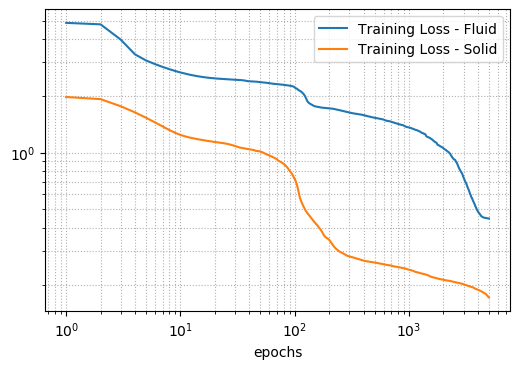

In [4]:
plt.figure()
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1,n_epochs+1), history_f, label="Training Loss - Fluid")
plt.plot(np.arange(1,n_epochs+1), history_s, label="Training Loss - Solid")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [5]:
test = pd.read_table('TestingData.txt', dtype='float')
t_test = torch.tensor(test.t).reshape(-1,1)

tf0_test_pred = my_network_f((t_test-t_test.mean())/t_test.std()).reshape(-1,).detach()
ts0_test_pred = my_network_s((t_test-t_test.mean())/t_test.std()).reshape(-1,).detach()

tf0_test_pred = tf0_test_pred*data_std[1] + data_mean[1]
ts0_test_pred = ts0_test_pred*data_std[2] + data_mean[2]

df = pd.DataFrame({'t': np.array(t_test.reshape(-1,)), 'tf0': np.array(tf0_test_pred), 'ts0': np.array(ts0_test_pred)})
df.to_csv('Task1_.txt', header = True, index = None)

In [6]:
tf_val = my_network_f(t_norm).reshape(-1,1)*data_std[1] + data_mean[1]
ts_val = my_network_s(t_norm).reshape(-1,1)*data_std[2] + data_mean[2]

error_f = torch.mean((tf0 - tf_val)**2)/torch.mean(tf0**2)
print("Relative Training Error: ", error_f.detach().numpy()**0.5*100, "%")
error_s = torch.mean((ts0 - ts_val)**2)/torch.mean(ts0**2)
print("Relative Training Error: ", error_s.detach().numpy()**0.5*100, "%")

Relative Training Error:  2.073531039059162 %
Relative Training Error:  0.7876974530518055 %


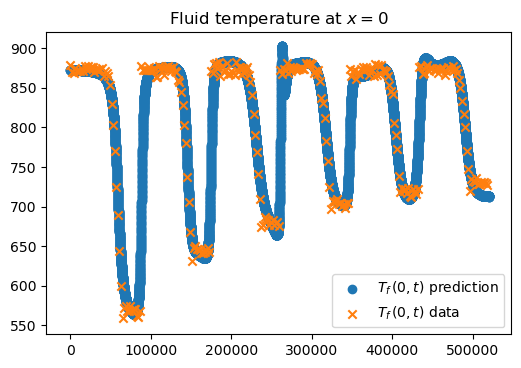

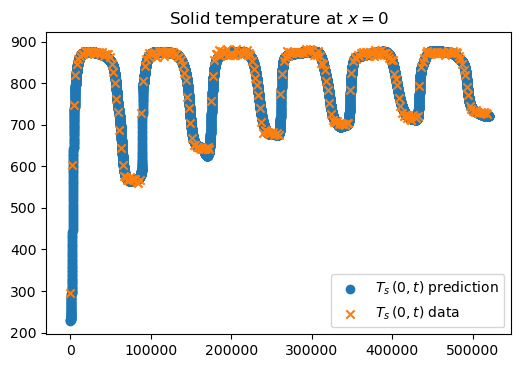

In [7]:
pred = pd.read_table('Task1_.txt', delimiter=',', dtype='float')

plt.figure()
plt.scatter(pred.t,pred.tf0)
plt.scatter(t,tf0,marker='x')
plt.legend(['$T_f\,(0,t)$ prediction','$T_f\,(0,t)$ data'])
plt.title('Fluid temperature at $x=0$')
plt.show()

plt.figure()
plt.scatter(pred.t,pred.ts0)
plt.scatter(t,ts0,marker='x')
plt.legend(['$T_s\,(0,t)$ prediction','$T_s\,(0,t)$ data'])
plt.title('Solid temperature at $x=0$')
plt.show()

# K-Fold validation

kf = KFold(n_splits=10)
n_split = kf.get_n_splits(t_norm)

average_train_error = 0.
average_validation_error = 0.
average_testing_error = 0.

for k, (train_index, test_index) in enumerate(kf.split(t_norm)):
    print("#################################")
    print("Running fold number ", k)
    # Split between training and validation data
    t_train_k, t_val_k = t_norm[train_index], t_norm[test_index]
    tf0_train_k, tf0_val_k = tf0_norm[train_index], tf0_norm[test_index]
    ts0_train_k, ts0_val_k = ts0_norm[train_index], ts0_norm[test_index]
    batch_size = t_train_k.shape[0]
    
    # Define the neural network
    my_network_f = NeuralNet_Seq(input_dimension=t_norm.shape[1], output_dimension=tf0_norm.shape[1], n_hidden_layers=4, neurons=20)
    my_network_s = NeuralNet_Seq(input_dimension=t_norm.shape[1], output_dimension=ts0_norm.shape[1], n_hidden_layers=4, neurons=20)
    # Random Seed for weight initialization
    retrain = 128
    # Xavier weight initialization
    init_xavier(my_network_f, retrain)
    init_xavier(my_network_s, retrain)
    
    
    if opt_type == "ADAM":
        optimizer_f = optim.Adam(my_network_f.parameters(), lr=0.001)
        optimizer_s = optim.Adam(my_network_s.parameters(), lr=0.001)
    elif opt_type == "LBFGS":
        optimizer_f = optim.LBFGS(my_network_f.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
        optimizer_s = optim.LBFGS(my_network_s.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
    else:
        raise ValueError("Optimizer not recognized")

    training_set_f = DataLoader(torch.utils.data.TensorDataset(t_train_k, tf0_train_k), batch_size=batch_size, shuffle=True)
    training_set_s = DataLoader(torch.utils.data.TensorDataset(t_train_k, ts0_train_k), batch_size=batch_size, shuffle=True)
    
    n_epochs = 1200
    # Train the model
    print('Fluid')
    history_f = fit_k(my_network_f, training_set_f, t_val_k, tf0_val_k, n_epochs, optimizer_f, p=2,  reg_param = 0.013, verbose=False )
    print('Solid')
    history_s = fit_k(my_network_s, training_set_s, t_val_k, ts0_val_k, n_epochs, optimizer_s, p=2,  reg_param = 0.025, verbose=False )

    # Compute network prediction
    tf0_val_pred = my_network_f(t_val_k)
    tf0_train_pred = my_network_f(t_train_k)
    tf0_test_pred = my_network_f(t_test)
    ts0_val_pred = my_network_s(t_val_k)
    ts0_train_pred = my_network_s(t_train_k)
    ts0_test_pred = my_network_s(t_test)

# Evaulate network performance
    relative_error_train = (torch.mean((tf0_train_pred.reshape(-1,) - tf0_train_k.reshape(-1,))**2)/torch.mean(tf0_train.reshape(-1,)**2) + torch.mean((ts0_train_pred.reshape(-1,) - ts0_train_k.reshape(-1,))**2)/torch.mean(ts0_train.reshape(-1,)**2))/2.0
    relative_error_val = (torch.mean((tf0_val_pred.reshape(-1,) - tf0_val_k.reshape(-1,))**2)/torch.mean(tf0_val.reshape(-1,)**2) + torch.mean((ts0_val_pred.reshape(-1,) - ts0_val_k.reshape(-1,))**2)/torch.mean(ts0_val.reshape(-1,)**2))/2.0
    relative_error_test = (torch.mean((tf0_test_pred.reshape(-1,) - tf0_test.reshape(-1,))**2)/torch.mean(tf0_test.reshape(-1,)**2) + torch.mean((ts0_test_pred.reshape(-1,) - ts0_test.reshape(-1,))**2)/torch.mean(ts0_test.reshape(-1,)**2))/2.0
    
    # Compute average network performance
    average_train_error = average_train_error + relative_error_train.item()**0.5/n_split
    average_validation_error = average_validation_error +  relative_error_val.item()**0.5/n_split
    average_testing_error = average_testing_error +  relative_error_test.item()**0.5/n_split